In [1]:
%matplotlib inline

In [59]:
import numpy as np
import healpy as hp
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')

from importlib import reload

import self_trig_all_sky as stas

In [91]:
reload(stas)

<module 'self_trig_all_sky' from '/mnt/lfs7/user/apizzuto/all_sky_vs_self_triggered/self_trig_all_sky.py'>

We want to simulate the sky, just dealing with the unique locations on the sky. The improved point source group found there to be ~200,000 - 400,000 unique locations in the Northern Sky with our current resolution and analysis methods. This corresponds to an nside of about 256

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


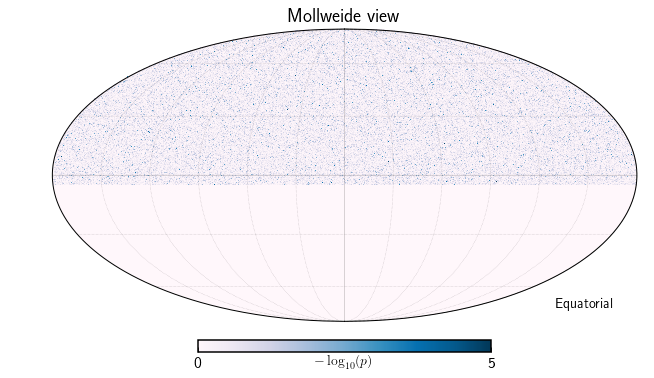

In [61]:
skymap = stas.get_one_skymap()
hp.mollview(skymap,
    coord="C",
    unit=r'$-\log_{10}(p)$',
    min=0., 
    max=5.
    )
hp.graticule(alpha=0.3, lw=0.5)

## First, figure out how many sources we need to consider in our binomial scan 
Out to which $k$ do we calculate $\min_kP_{binom}(k)$?

### Let's make sure that only checking the most significant 10000 sources is enough. This is just a computational speedup

First, we look at one scan, just to see what it looks like

86


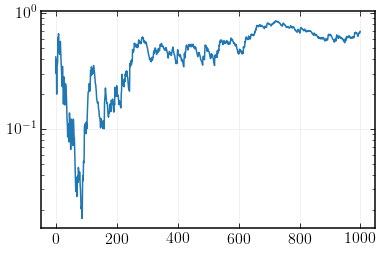

In [92]:
p, sc = stas.get_one_scan()
plt.plot(sc[:1000])
plt.yscale('log')
print(np.argmin(sc))

Now, repeat for a bunch of trials, keeping track of the minimum $k$. We only scan $k$ out to $k=10,000$ (just for computational speedup), so we want to make sure the distribution cuts off at least mostly before that 10,000 number

In [37]:
binom_ps, num_sources = stas.run_full_binom_trials(num=200, return_num=True)

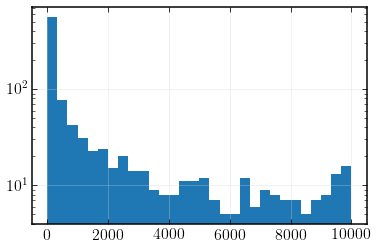

In [47]:
plt.hist(num_sources, bins=20)
plt.yscale('log')
plt.show()

It looks like most of the trials are concentrated at having the most significant $k$ in the binomial scan for a small number of sources. We are obviously missing some sources, but I'm gonna say it's okay for now, might need to revisit this at the end. 

Because we have the distribution, let's also just take a look at the binomial p-value distribution

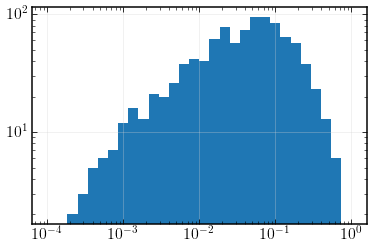

In [46]:
plt.hist(binom_ps, bins=np.logspace(-4., 0., 31))
plt.yscale('log')
plt.xscale('log')

This is just an example of how to get one trial and look at the binomial scan

## Now it's time to inject signal

We need to come up with a way to simulate a set of sources, and then take that set of sources and simulate two scenarios:
1. Self-triggered: calculate which sources give you alerts, for those that do calculate the number of additional GFU events, then sample a p-value for those skymaps (using the trials I already have for alert event followup time-integrated stuff
2. All-sky: calculate the number of events (summed alerts and GFU), then sample a p-value for that number of injected events (no skymap). We need to run these trials for a variety of declinations and injected signal strengths

Replace a set of pvalues from the master list with those from these sources, then perform a binomial test

In [78]:
import francis.universe.transient_universe as uni

In [75]:
from importlib import reload

In [85]:
reload(uni)

<module 'francis.universe.transient_universe' from '/data/user/apizzuto/fast_response_skylab/alert_event_followup/FRANCIS/francis/universe/transient_universe.py'>

In [86]:
lumi = 'SC'
evol = 'MD2014SFR'
density = 1e-10
diffuse_flux_norm = 1.5e-8
diffuse_flux_ind = 2.5

uni = uni.SteadyUniverse(
    lumi, evol, density,
    diffuse_flux_norm, diffuse_flux_ind, 
    data_years=8.6)
uni

In [88]:
uni.create_universe()

In [90]:
uni.find_alerts()

In [92]:
uni.sources

{'dec': array([  8.11040381,  31.1315483 ,  11.8052132 ,  26.62953827,
         77.25110671,  15.27998513,  29.41985119, -64.10497016,
          0.47000835,  17.48907336,   3.38512349,  19.64495778,
         -0.62888822,   5.80705882,  53.7629225 ,  34.88589559,
         45.65715031,  79.05956502,  11.73968752,  17.42680086,
         29.34799244,  18.00428921,  29.28354225,  23.75100544,
         44.52505438,  -3.68811873,  -2.28875917,  27.10681717,
          7.61883465,  25.61484815,  15.76913138,  28.106477  ,
         10.29877787,  -2.43172192,  68.17639981,  49.92384203,
         -4.55027737,  43.85009419,  10.14060072,  20.88841037,
          3.53310623,  14.66255755,  11.85009945,   7.77131674,
         47.34041582,  58.69009739, -76.99867322,   2.14887211,
        -64.72625444,  -3.33808193,  54.41052567,  28.13819628,
         18.37079202,  59.91782417,  29.06705566,  -0.13959514,
         77.89067843,  66.75716465]),
 'flux': array([  6.42363216,   1.72139453,   1.2461795 ,  